# **Import**

The `pycadet` package, together with dependencies, can be installed using `pip`. It is however recommneded to resolve most of the [requirements](https://github.com/tomasplsek/CADET) beforehand based on your envirnoment, your needs, etc. Currently, the CADET model can only be loaded with Keras2 (recommended version for `keras` and `tensorflow` is 2.12).

In [1]:
# !pip install pycadet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import center_of_mass

from pycadet import rebin, make_prediction, decompose, rotangle_and_ellip, make_3D_cavity, CADET

# **Data**

The ***CADET*** pipeline inputs either raw *Chandra* images in units of counts (numbers of captured photons) or exposure-corrected images. When using exposure-corrected data, images are automatically normalized by the lowest pixel value (except for zeros) so that all pixels are higher than or equal to 1. For images with many point sources, we recommend filling the point sources with surrounding background level using Poisson statistics ([dmfilth](https://cxc.cfa.harvard.edu/ciao/ahelp/dmfilth.html) within [CIAO](https://cxc.harvard.edu/ciao/)).

Here we demonstrate the package using two exemplary images:

NGC4649.fits - image centred at the centre of the M60 galaxy, cropped to 512x512 pixels, and with filled point sources\
NGC4778.fits - exposure-corrected image of the original size of 2510x1916 pixels, includes point sources

In [3]:
!wget "https://github.com/tomasplsek/CADET/raw/main/example/NGC4649.fits" -O "NGC4649.fits"
!wget "https://github.com/tomasplsek/CADET/raw/main/example/NGC4778.fits" -O "NGC4778.fits"

--2024-08-21 18:05:36--  https://github.com/tomasplsek/CADET/raw/main/example/NGC4649.fits
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tomasplsek/CADET/main/example/NGC4649.fits [following]
--2024-08-21 18:05:37--  https://raw.githubusercontent.com/tomasplsek/CADET/main/example/NGC4649.fits
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2462400 (2.3M) [application/octet-stream]
Saving to: ‘NGC4649.fits’

NGC4649.fits        100%[===================>]   2.35M  9.56MB/s    in 0.2s    

2024-08-21 18:05:37 (9.56 MB/s) - ‘NGC4649.fits’ saved [2462400/2462400]

--2024-08-21 18:05:37--  https://g

(529, 529)

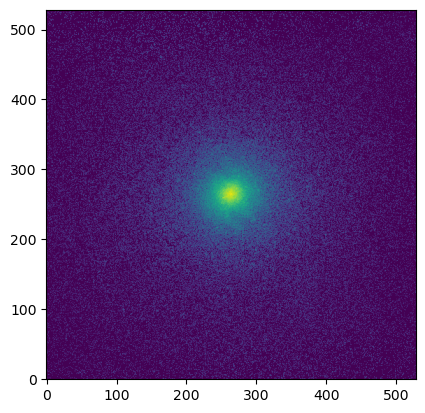

In [4]:
data = fits.getdata("NGC4649.fits")

plt.imshow(np.log10(data+1), origin="lower")

data.shape

(2510, 1916)

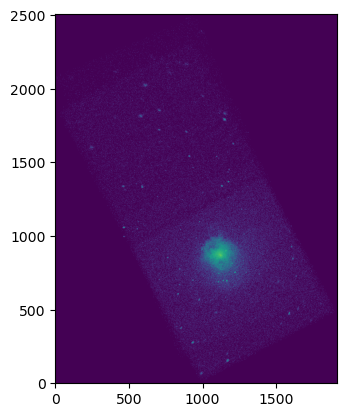

In [5]:
data = fits.getdata("NGC4778.fits")

plt.imshow(np.log10(data+1e-10), origin="lower")

data.shape

# **Rebin**

The ***CADET*** model can only input 128x128 images. Input images must therefore be cropped and binned to 128x128 pixels, which can be done using the `rebin` function. The crop size can be specified by the parameter `scale` (size = scale * 128 pixels). Images should either be centred at the galaxy center beforehand or their can be centred by specifying the `ra` and `dec` parameters. The re-binning is performed using *Astropy* and *Numpy* libraries and can only handle integer binsizes. For floating point number binning, we recommend using [dmregrid](https://cxc.cfa.harvard.edu/ciao/ahelp/dmregrid.html).

Arguments of the `rebin` function:\
`fname` - string; name of the input file\
`scale` - integer; specifies the crop size (size = scale * 128 pixels)\
`ra` - string or float; right ascension of the centre of the galaxy (optional)\
`dec` - string or float; declination of the centre of the galaxy (optional)\
`shift` - bool; if True, output shape is 130x130 instead of 128x128 (optional, default: `shift=False`)

In [6]:
from pycadet import rebin

In [7]:
data, wcs = rebin("NGC4649.fits", scale=2, ra="12:43:40.0057", dec="11:33:10.456")

(128, 128)

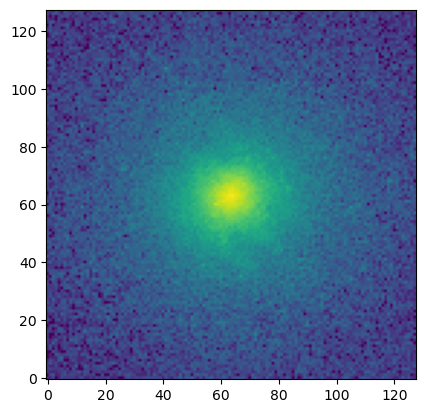

In [8]:
plt.imshow(np.log10(data+1), origin="lower")

data.shape

# **Make prediction**

The ***CADET*** model can be applied on the obtained binned image (`data`) by calling the `make_prediction` function with the binned image as an argument. On the output of this function, there is a pixel-wise prediction with values ranging from 0 to 1, which represents whether the corresponding pixel belongs to a cavity or not.

Arguments of the `make_prediction` function:\
`data` - numpy array; input image of shape (128, 128) or (130, 130) if `shift=True`\
`shift` - bool; if True, the prediction is averaged by shifting the image by +/- 1 pixel (optional, default: `shift=False`)

In [9]:
from pycadet import make_prediction

In [10]:
%time pred = make_prediction(data)

2024-08-21 18:05:41.502154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 13.6 s, sys: 259 ms, total: 13.9 s
Wall time: 2.82 s


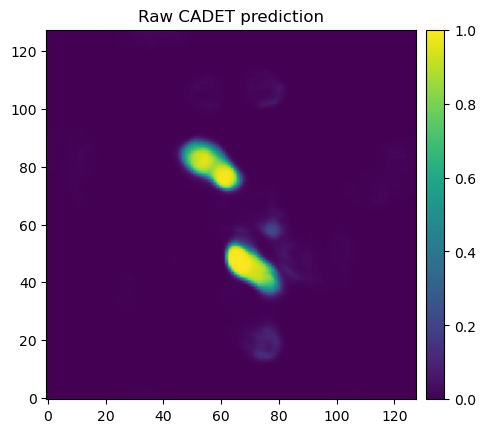

In [11]:
from matplotlib.colors import Normalize

plt.title("Raw CADET prediction")
plt.imshow(pred, origin="lower", norm=Normalize(0,1))
plt.colorbar(fraction=0.046, pad=0.02);

## **Shifting**

To suppress uncertainties connected with improper image centering as well as with activating slightly different neurons in the ***CADET*** model, the ***CADET*** pipeline includes the possibility to shift the centre of the input image by +/- 1 pixel in both X and Y directions. If `shift=True`, the final predictions is thus averaged from 9 differently shifted input images (the execution time is approximatelly 8 times longer).

When using the shifting option, the `make_prediction` function inputs 130x130 images. To obtain the binned image of this shape, the `shift=True` option also needs to be set in the `rebin` function. The shape of the resulting pixel-wise prediction is however still 128x128 pixels.

In [12]:
data, wcs = rebin("NGC4649.fits", scale=2, ra="12:43:40.0057", dec="11:33:10.456", shift=True)

data.shape

(130, 130)

In [13]:
%time pred = make_prediction(data, shift=True)

pred.shape

CPU times: user 1min 51s, sys: 1.89 s, total: 1min 53s
Wall time: 8.71 s


(128, 128)

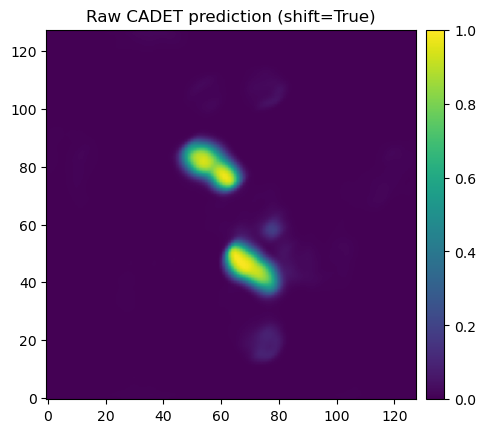

In [14]:
plt.title("Raw CADET prediction (shift=True)")
plt.imshow(pred, origin="lower", norm=Normalize(0,1))
plt.colorbar(fraction=0.046, pad=0.02);

# **Decompose**

To allow manipulation with individual X-ray cavities, the pixel-wise prediction obtained by the `make_prediction` function can be further decomposed into individual cavities using the DBSCAN algorithm (`decompose` function). However, prior to decomposition, the raw pixel-wise prediction must be thresholded. In order to simultaneously calibrate the volume error and the false positive rate, we introduced two discrimination thresholds (for more info see [Plšek et al. 2023](https://arxiv.org/abs/2304.05457)) with default values of 0.4 and 0.6, respectively. However, both discrimination thresholds are changeable and can be set to an arbitrary value between 0 and 1.

Arguments of the `decompose` function:\
`pred` - numpy array; pixel-wise prediction of shape (128, 128)\
`th1` - float; volume calibrating discrimination threshold (optional, default: `th1=0.4`)\
`th2` - float; FP rate calibrating discrimination threshold (optional, default: `th2=0.6`)\
`amin` - integer; minimal cavity area in units of pixels (optional, default: `amin=10`)

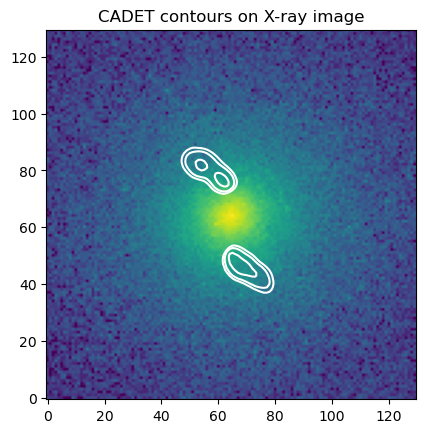

In [15]:
plt.title("CADET contours on X-ray image")
plt.imshow(np.log10(data+1), origin="lower");

plt.contour(pred, levels=[0.4, 0.6, 0.9], colors="white");

In [16]:
from pycadet import decompose

In [17]:
cavities = decompose(pred, th1=0.4, th2=0.6)

len(cavities), cavities[0].shape

(2, (128, 128))

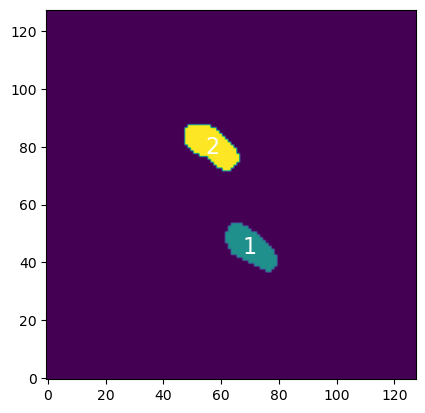

In [18]:
cavs = np.zeros((128,128))
for i, cav in enumerate(cavities):
    cavs += (i+1) * np.where(cav > 0, 1, 0)

plt.imshow(cavs, origin="lower")
for i, cav in enumerate(cavities):
    plt.text(*center_of_mass(cav)[::-1], i+1, fontsize=16, ha="center", va="center", c="w")

# **Cavity rotation angle and ellipticity**

To estimate the angle at which individual X-ray cavities are oriented we can utilize the Principal Component Analysis ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)), which performs Singular Value Decomposition (SVD). We then assume that the orientation of the main principal component corresponds to the orientation of the cavity and calculate the rotation angle.
Assuming that the cavity predictions are approximately elliptical, we can also make an estimate of their ellipticity. To do this, we can use the singular values $\vec{\sigma}$ obtained from the PCA and calculate the ellipticity as $e = 1 - \frac{\min([\sigma_1,\,\sigma_2])}{\max([\sigma_1,\,\sigma_2])}$. Assuming an elliptical shape, we can even express the semi-major and semi-minor axes using the formula $S = \pi a b$.

Arguments of the `rotangle_and_ellip` function:\
`cavity` - numpy array, individual cavity matrix (128x128)

Cavity 1
--------
Rotation angle: -38.3°
Ellipticity: 0.53
Semi-major axis: 9.4 px
Semi-minor axis: 4.5 px

Cavity 2
--------
Rotation angle: -35.3°
Ellipticity: 0.52
Semi-major axis: 9.4 px
Semi-minor axis: 4.6 px



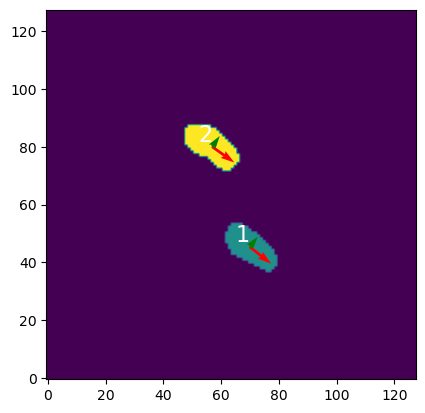

In [19]:
from pycadet import rotangle_and_ellip

plt.imshow(cavs, origin="lower")
for i in range(2):
    angle, e = rotangle_and_ellip(cavities[i].T)
    a = (np.sum(cavities[i]) / np.pi / (1-e))**0.5
    b = a * (1-e)

    plt.text(*center_of_mass(cavities[i])[::-1], i+1, fontsize=16, ha="right", va="bottom", c="w")

    center = center_of_mass(cavities[i].T)
    plt.quiver(center[0], center[1], np.cos(angle)*a, np.sin(angle)*a, 
               color='r', scale=1, scale_units='xy', angles='xy')
    plt.quiver(center[0], center[1], -np.sin(angle)*b, np.cos(angle)*b, 
               color='g', scale=1, scale_units='xy', angles='xy')

    print(f"Cavity {i+1}\n--------")
    print(f"Rotation angle: {np.degrees(angle):.1f}°")
    print(f"Ellipticity: {e:.2f}")
    print(f"Semi-major axis: {a:.1f} px")
    print(f"Semi-minor axis: {b:.1f} px\n")

# **Make 3D cavity**

The decomposed cavities can be turned into a 3D cavity model using a `make_3D_cavity` function. The 3D models of X-ray cavities are created under the assumption of rotational symmetry along the direction from the galactic centre towards the centre of the cavity. The depth of the cavity at each point along this direction is then assumed to be equal to its width. The output of the `make_3D_cavity` function is a 3D matrix of shape (128, 128, 128) and the resulting 3D cavity model can be saved in the `.npy` format and can be used for further calculations (e.g. cavity energy estimation).

Arguments of the `make_3D_cavity` function:\
`cavity` - numpy array, individual cavity matrix (128x128)

In [20]:
from pycadet import make_3D_cavity

In [21]:
cube1 = make_3D_cavity(cavities[0], rotate_back=True)
cube2 = make_3D_cavity(cavities[1], rotate_back=True)
cube = cube1 + cube2
cubes = [cube1, cube2]

cube.shape

(128, 128, 128)

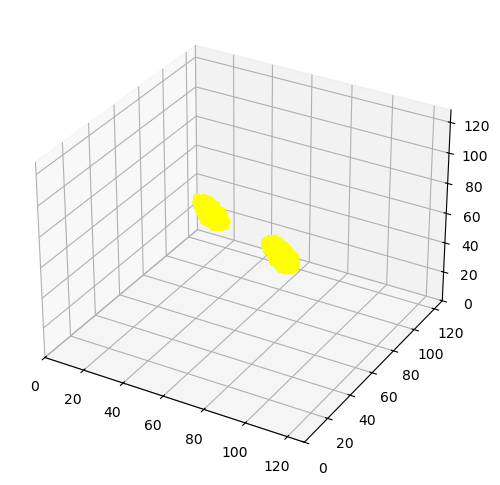

In [22]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(cube, edgecolor="yellow", facecolors="yellow", alpha=0.5)
ax.set_xlim(0,128)
ax.set_ylim(0,128)
ax.set_zlim(0,128);

# **Cavity area & volume**

In [23]:
# Get angular size of 1 pixel from the WCS
angular_scale = wcs.pixel_scale_matrix[1,1] * 3600

for i, (cav, cube) in enumerate(zip(cavities, cubes)):
    print(f"Cavity {i+1}\n--------")
    print(f"area: {np.sum(cav):.0f} px² (binned pixels)")
    print(f"area: {np.sum(cav)*angular_scale**2:.0f} arcsec²")
    print(f"volume: {np.sum(cube):.0f} px³ (binned pixels)")
    print(f"volume: {np.sum(cube)*angular_scale**3:.0f} arcsec³\n")

Cavity 1
--------
area: 132 px² (binned pixels)
area: 128 arcsec²
volume: 1090 px³ (binned pixels)
volume: 1039 arcsec³

Cavity 2
--------
area: 135 px² (binned pixels)
area: 131 arcsec²
volume: 1264 px³ (binned pixels)
volume: 1204 arcsec³



# **CADET pipeline**

The `pycadet` package also includes the full CADET pipeline. The pipeline takes an input image (`fname`), crops it on multiple scales specified by the `scales` parameter around central coordinates defined by the `ra` and `dec` parameters (uses centre of the image if not specified), and bins them to the desired shape (depending on the `shift` parameter). It then applies the CADET model to images of individual scales and decomposes the predictions into individual cavities.

The pipeline also creates a folder with the same name as the FITS file, and saves the corresponding pixel-wise as well as decomposed cavity predictions in FITS format, while also properly preserving the WCS coordinates. The pipeline also generates 3D representations of the cavities and saves them in the `.npy` format in the *cubes* folder. The pipeline also creates a PNG file showing the pixel-wise predictions for each scale as contours superimposed on the original images.

Arguments of the `CADET` function:\
`fname` - string; name of the input file\
`scales` - list of integers; specifies the crop sizes (size = scale * 128 pixels)\
`ra` - string or float; right ascension of the centre of the galaxy (optional)\
`dec` - string or float; declination of the centre of the galaxy (optional)\
`shift` - bool; if True, output shape is 130x130 instead of 128x128 (optional, default: `shift=False`)\
`th1` - float; volume calibrating discrimination threshold (optional, default: `th1=0.4`)\
`th2` - float; FP rate calibrating discrimination threshold (optional, default: `th2=0.6`)\
`plot_smooth` - bool; whether to smooth the plotted X-ray image (optional, default: `plot_arrows=False`)\
`plot_arrows` - bool; whether to vizualize rotation angles of cavities (optional, default: `plot_arrows=False`)

In [1]:
from pycadet import CADET

---- Running CADET ----
Reading file: NGC4649.fits

Original image size: 529x529 pixels
Selected scales: [1, 2, 3, 4]

RA & DEC not specified.
Using the center of the image:
RA:  12:43:39.96 hours
DEC: 11:33:09.96 degrees

Creating directories:
NGC4649/
  ├ predicitons/
  ├ decomposed/
  └ cubes/

Processing the image on following scales:
128 pixels:  

2024-08-21 18:09:43.165876: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


detected 2 cavities
256 pixels:  detected 2 cavities
384 pixels:  detected 2 cavities
512 pixels:  detected 2 cavities

Saving results:
NGC4649/cavity_properties.txt

area [px²] and volume [px³] are expressed in units of binned pixels
volume [arcsec³] - calculated assuming rotational symmetry along the axis from galaxy center to cavity center


area [px²]  area [arcsec²]  volume [px³]  volume [arcsec³]  \
scale      cavity                                                               
128 pixels 1              342              83          4918               586   
           2              395              96          5420               645   
256 pixels 1              138             134           910               867   
           2              151             146          1098              1046   
384 pixels 1               58             125           238               765   
           2               73             159           356              1145   
512 pixels 1               16              60            44               335   
           2               32             122           122               930   

                   angle [deg]  ellipticity  
scale      cavity                            
128 pixels 1             -38.1         0.49  
           2             -34.3         0.63  
256 pixels 1             -40.1         0.54  
           2             -36.9         0.54  
384 pixels 1             -41.7         0.39  
           2             -34.6         0.44  
512 pixels 1             116.7         0.17  
           2             -39.2         0.37

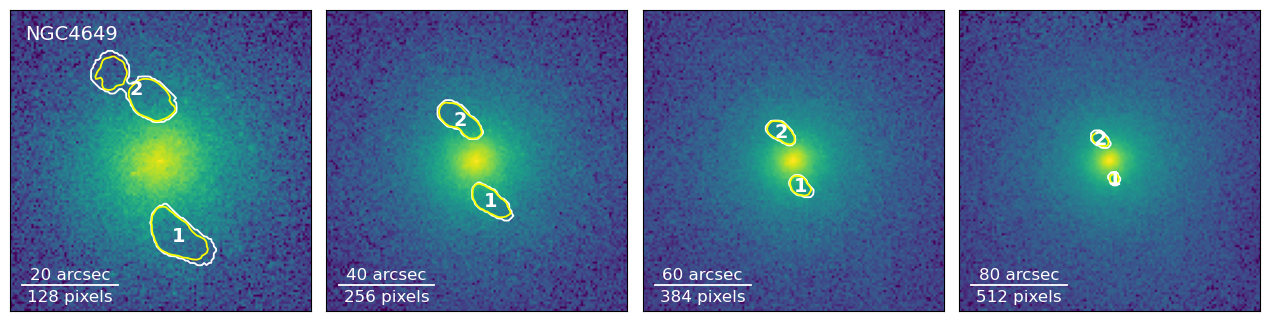

In [2]:
CADET("NGC4649.fits", scales=[1,2,3,4], th1=0.4, th2=0.6)

---- Running CADET ----
Reading file: NGC4778.fits

Original image size: 2510x1916 pixels
Selected scales: [1, 2, 3, 4, 5]
RA:  12:53:05.6621 hours
DEC: -9:12:14.883 degrees

Creating directories:
NGC4778/
  ├ predicitons/
  ├ decomposed/
  └ cubes/

Processing the image on following scales:
128 pixels:  WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7d11d506f0d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more detai

area [px²]  area [arcsec²]  volume [px³]  volume [arcsec³]  \
scale      cavity                                                               
128 pixels 1              983             238         27670              3295   
           2               63              15           414                49   
256 pixels 1              299             289          4508              4295   
           2              892             864         20292             19333   
384 pixels 1              165             359          2310              7428   
           2              479            1045          8274             26606   
           3              267             582          3346             10759   
512 pixels 1              102             396           994              7576   
           2              317            1226          4314             32882   
           3              142             551          1110              8461   
640 pixels 1               76             462           556              8277   
           2              195            1177          2072             30846   
           3               59             355           414              6163   

                   angle [deg]  ellipticity  
scale      cavity                            
128 pixels 1              -9.9         0.06  
           2             100.6         0.26  
256 pixels 1               0.5         0.14  
           2              33.9         0.25  
384 pixels 1              16.9         0.40  
           2              38.4         0.27  
           3             -32.8         0.15  
512 pixels 1              12.2         0.41  
           2              39.7         0.29  
           3             134.3         0.14  
640 pixels 1              16.3         0.33  
           2              36.4         0.30  
           3             125.9         0.13

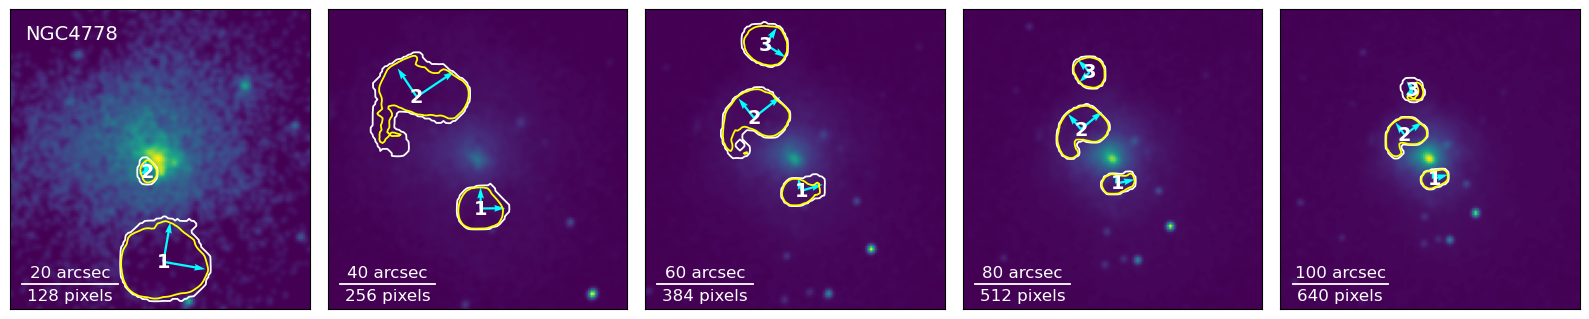

In [3]:
CADET("NGC4778.fits", scales=[1,2,3,4,5], ra="12:53:05.6621", dec="-9:12:14.883", th1=0.4, th2=0.7, plot_smooth=True, plot_arrows=True)